# Principal component analysis (PCA) and clustering

The purpose of this lab is to illustrate how principal component analysis can be used to reduce the number of dimensions of a data set while preserving the most significant variations among the data points.  We'll see visually that if there are clusters planted in the data, then they will emerge.  Although we won't get into it in this lab, basic clustering algorithms such as the K-means algorithm, could be applied to the reduced dimensional data to identify the clusters instead of our eyeballs method.  We'll also see the importance of standardizing the data in case the measurements of different data coordinates are on drastically different scales.

Below is our typical list of imports. You may notice that this is a bit different or more complex from some of the previous labs. This code is just allowing us to do some fancier things with some of our graphs. Feel free to look up some of the modules if you are interested.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as st
from scipy.stats import multivariate_normal
import csv
from mpl_toolkits.mplot3d import Axes3D   #Toolkits are collections of application-specific functions that extend matplotlib
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):  # Arrow3D([a,d],[b,e],[c,f]) draws arrow (a,b,c)--> (d,e,f)
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
print ('Modules Imported!')

#  From .csv file, read headers, then load numbers into array x
#  Warning: unfortunately there are many types of .csv files
#  This code assumes the .csv file has comma separate heading in the first row
#  and comma separated numbers in the remaining rows.
def data_load(str):
    csv_path = str
    with open(csv_path,'rt') as csvfile:  #After code under "with open as" is completed, csvfile is closed
        reader=csv.reader(csvfile)
        headings=next(reader)
        print ("Reading csv file with headers:\n  ","\n   ".join(headings),"\n")
        x=[]
        for row in reader:
            x.append(row)    
    return(np.array(x,dtype=float).T)   # returns data with one column for each multidimensional sample

print ("Function loaded")


Modules Imported!
Function loaded


In the following we consider the principal components analysis (PCA) of the three dimensional data formed by (quiz sum, exam 1, exam 2) scores in the ECE 313 data.  At this point we will no longer be using the $Y$ values, becasue we want to try visualizing the data, and we're limited to visualizing three dimensions at a time.   Below you will work with 15 dimensional data, but use dimensionality reduction to visualize the data in two or three dimenions.  By starting out thinking about three dimensional data, we can see it all!   If the three variables, in this case quiz sum, exam 1, and exam 2, were uncorrelated, the structure of the geometry of the data would be pretty simple.   It is not difficult to guess what a scatterplot of the data would look like, if we know the means and variances of each of the scores.   The idea of PCA is that any probability distribution (such as the empirical distribution we are using) has uncorrelated coordinates under a change in coordinate system that preserves distances.   The key is the eigen decomposition of the covariance matrix, as illustrated in the next two boxes of code.  The eigen vectors produced (they are the columns of the matrix eig\_vec) are orthogonal length one vectors that represent the new coordinate system, and the eigenvalues represent the variances of the data along the directions of each of the eigen vectors.  The code below prints the square roots of the eigen values, which gives the standard deviations in the different new coordinate directions.

The last assertion of the code checks that the covariance matrix has the following representation in terms of the eigenvalues $\lambda_i$ and eigenvectors $v_i$:
$$  \Sigma_{XX} = \sum_{i=1}^3  \lambda_i v_iv_i^T   .$$

In [2]:
###  Load the 313scores and compute covariance matrix and mean
###  for the first three scores (quiz sum, exam 1, exam 2)

x=data_load("313scores.csv")   # One column per student, x.shape[1] is number of students
dim=3  # Number of scores per student we'll work with
mean_x=np.mean(x,axis=1).reshape(-1,1)   # reshape makes mean_x a 2-d array of width one
                                         # so when we subtract mean_x from the matrix x
                                         # the subtraction is done for each column of x
                                         # The -1 is a wildcard value for height
covariance_matrix = np.dot(x-mean_x,(x-mean_x).T)/(x.shape[1])
EX=mean_x[0:dim]
CovXX=covariance_matrix[0:dim,0:dim]


# eigendecomposition of covariance matrix CovXX
# The eigen vectors are placed in the columns of the matrix eig_vec
# Note that CovXX is computed above

eig_val, eig_vec = np.linalg.eig(CovXX)
print ("square roots of eigenvalues:", np.sqrt(eig_val),"\neigen vectors (as columns):", '\n', eig_vec)
        
assert (CovXX == np.dot(eig_vec,np.dot(np.diagflat(eig_val),eig_vec.T))).all, "eigen decomposition"

Reading csv file with headers:
   quiz sum
   Exam 1
   Exam 2
   Final 

square roots of eigenvalues: [27.33335818 19.91860738 11.73400701] 
eigen vectors (as columns): 
 [[ 0.75366733  0.65721366 -0.00746694]
 [ 0.37613763 -0.44060095 -0.81510201]
 [ 0.53898612 -0.61150716  0.57926933]]


If we think of a scatterplot of the data as forming a blob in three dimensional space, then the mean vector is located at the center of mass of the blob.   If the blob is generated by a large number of identically Gaussian random variables, its level sets would be concentric elipses.  The principal axes of the elipses are given by the three eigenvectors, and the relative thickness of the elipses in the three dimensions are given by the square roots of the eigenvectors.   Those values give the standard deviation of the data in the three principal directions.  This geometric picture is illustrated by the following code.

In [3]:
# Principal component analysis (PCA) representation of 3d data
#
# Scatter plot of data, overlaid with the three eigen vectors, scaled by
# square root of eigenvalues, and all translated to the sample mean.


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')  #ax is a 3-d aware axes object 

MX=EX.reshape(-1)  # MX is plain np.array version of 3x1 np.array EX
ax.plot(x[0,:], x[1,:],\
    x[2,:], 'o', markersize=8, color='blue', alpha=0.5)
ax.plot([MX[0]],[MX[1]],[MX[2]], 'o', \
    markersize=10, color='orange', alpha=1.0)
print ("Mean vector:",MX,"\nSquare roots of eigenvalues:", np.sqrt(eig_val))

for i in range(3):   #Iterate through (eigenvalue, eigenvector) pairs
    a = Arrow3D([MX[0], MX[0]+np.sqrt(eig_val[i])*eig_vec[0,i]], \
                [MX[1], MX[1]+np.sqrt(eig_val[i])*eig_vec[1,i]], \
                [MX[2], MX[2]+np.sqrt(eig_val[i])*eig_vec[2,i]], \
                     mutation_scale=20, lw=3, arrowstyle="-|>", color="orange")
    ax.add_artist(a)
ax.set_xlabel('quiz sum')
ax.set_ylabel('exam 1')
ax.set_zlabel('exam 2')

plt.title('Scatter plot of data and PCA representation')

plt.show()

Mean vector: [80.63084112 70.61214953 61.54205607] 
Square roots of eigenvalues: [27.33335818 19.91860738 11.73400701]


AttributeError: 'Arrow3D' object has no attribute 'do_3d_projection'

<Figure size 1000x1000 with 1 Axes>

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 1:</SPAN>** Use the code given above to help you with the following: 
<ol><li>Generate $N=1000$ samples of three dimensional Gaussian random vectors with mean zero and covariance matrix $\Sigma =\left(\begin{array}{ccc} 1& 0 & 0 \\0 & 4 & 0 \\ 0 & 0 & 9  \end{array}\right).$ (Hint: You could use multivariate_normal.rvs, as used in previous lab and used below.)
<li> Calculate the covariance matrix, $\widehat{\Sigma},$ for the emirical distribution of the data you created. (Some code in Lab 13 might be useful here.)
<li> Calculate the Frobenious norm of the estimation error matrix, $\Sigma - \widehat{\Sigma}.$  (Hint: The Frobenius norm of a matrix is the square root of the sum of the squares of the elements, and is computed by np.linalg.norm()).
<li> Calculate the square roots of the eigenvales and the eigenvectors for both $\Sigma$ and $\widehat{\Sigma}$
and compare.  (They should be close, but possibly in different order, and the eigenvectors could be multiplied through by -1.)
<li>  Calculate and display a 3D scatter plot of the data with the PCA representation of the data overlaid.  Comment on how accurately the eigenvectors and eigenvalues are captured by the data for $N=100$ and $N=1000.$  (Hint: Decrease the transparency value alpha when more points are plotted so the arrows can still be seen.) 
</ol>

In [5]:
# Your code here 
covariance_matrix = np.array([[1, 0, 0], [0, 4, 0], [0, 0, 9]])
random_variable = multivariate_normal.rvs(np.zeros(3),covariance_matrix,1000).T
Em = np.cov(random_variable)
print("The emirical distribution of the data is: ", Em)
print("The Frobenious norm of the estimation error matrix is: ", np.linalg.norm(covariance_matrix - Em))
e_val, e_vec = np.linalg.eig(covariance_matrix)
print("Square root of eigen values for cov: ", np.sqrt(e_val))
print("eigen vector for cov: ", e_vec)
e_val, e_vec = np.linalg.eig(Em)
print("Square root of eigen values for emirical distribution: ", np.sqrt(e_val))
print("eigen vector for emirical distribution: ", e_vec)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')  #ax is a 3-d aware axes object 
M = np.mean(random_variable, axis=1).reshape(-1,1)
temp = M[0:3]
MX= temp.reshape(-1) # MX is plain np.array version of 3x1 np.array EX
ax.plot(random_variable[0,:], random_variable[1,:],\
    random_variable[2,:], 'o', markersize=8, color='blue', alpha=0.5)
ax.plot([MX[0]],[MX[1]],[MX[2]], 'o', \
    markersize=10, color='orange', alpha=1.0)
print ("Mean vector:",MX,"\nSquare roots of eigenvalues:", np.sqrt(e_val))

for i in range(3):   #Iterate through (eigenvalue, eigenvector) pairs
    a = Arrow3D([MX[0], MX[0]+np.sqrt(e_val[i])*e_vec[0,i]], \
                [MX[1], MX[1]+np.sqrt(e_val[i])*e_vec[1,i]], \
                [MX[2], MX[2]+np.sqrt(e_val[i])*e_vec[2,i]], \
                     mutation_scale=20, lw=3, arrowstyle="-|>", color="orange")
    ax.add_artist(a)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('Scatter plot of data and PCA representation')
plt.show()

The emirical distribution of the data is:  [[ 1.04547335 -0.02982374  0.10507075]
 [-0.02982374  3.91094993  0.52618594]
 [ 0.10507075  0.52618594  8.91837673]]
The Frobenious norm of the estimation error matrix is:  0.7708839212137715
Square root of eigen values for cov:  [1. 2. 3.]
eigen vector for cov:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Square root of eigen values for emirical distribution:  [1.02156356 2.99572511 1.96388364]
eigen vector for emirical distribution:  [[-0.99981444 -0.0127912  -0.01440363]
 [-0.01300673 -0.10327949  0.99456733]
 [ 0.0142093  -0.99457012 -0.10309395]]
Mean vector: [ 0.01207857 -0.02028577 -0.01509813] 
Square roots of eigenvalues: [1.02156356 2.99572511 1.96388364]


AttributeError: 'Arrow3D' object has no attribute 'do_3d_projection'

<Figure size 1000x1000 with 1 Axes>

__Answer__: We get more accurate eigen vector and values when N=1000 which makes sense due to the law of large numbers

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 1</SPAN>**

Next we will use the PCA method to examine some data where each sample has more than three dimensions.  We'll try 15 dimensions.   It is perhaps impossible for humans to visualize fifteen dimensional space, so for the purposes of visualization (and other tasks, such as clustering) we would like to reduce the dimensionality of the data, while trying to preserve the structure of the data as much as possible.  An obvious way to reduce the dimensionality is to use only three of the coordinates of each data sample. If, for example, we use three out of fifteen coordinates for each data sample, we are essentially ignoring 80% of the data.  We may be able to improve on that by trying different sets of three coordinates to look at.    The principal components representation (PCA) of the data offers a better approach.   The eigenvectors produced by python are normalized to be unit length vectors, and they are orthogonal to each other.   That means they are suitable for a change of coordinates.   Indeed, if $eigvec$ is the matrix such that the columns are the eigenvectors, and if $y=eigvec^T*x$ (using ordinary matrix times vector multiplication),  then $y$ represents the same point as $x,$  but relative to the basis formed by the eigen vectors.

The next problem explores this question for some randomly generated data in which each data vector has one of four unobserved random types.  The next cell generates the data.  For the first three scores of ECE 313 data, and for the Gaussian data you generated above, the scatter plots should form an elliptical blob of data.   However, for the data generated next, the data vectors of different types have different means.  All the means lie in a two or three dimensional space.   That causes the data to be more spread out in the directions that the mean vectors are in.   Thus, by doing a PCA analysis, the directions with the largest and second largest eigenvalues, will allow us to see the separated clusters (if the distance between cluster centers is large enough compared to the radii of the clusters).

In [6]:
## data15()  DATA GENERATOR FUNCTION   Start with standard 15 dimensional Gaussian samples.
## Add a mean vector to each sample, selected at random from among the four columns
## of mu using probability vector p.  For the given example, mu has rank two
## and a 2-D plot is able to distinguish the four clusters
## Signal factor scales the distance between cluster centers
def data15(signal_factor, num_samples, version):   # version should be 0,1,or 2.
    print ("signal_factor=",signal_factor, "num_samples=",num_samples,"  version=",version)
    dim=15  # Dimension of the random vectors
    planted_cov=np.identity(dim)
    x15 = multivariate_normal.rvs(np.zeros(dim),planted_cov,num_samples).T
    mu=np.array([[0, 0, 0, 0, 0,  0,  0,  0,  0,  0, 0,0,0,0,0],
                 [0, 0, 0, 0, 0,  1,  1,  1,  1,  1, 0,0,0,0,0],
                 [0, 0, 0, 0, 0,  0,  0,  0,  0,  0, 1,1,1,1,1],
                 [0, 0, 0, 0, 0,0.5,0.5,0.5,0.5,0.5, 1,1,1,1,1]]).T
    # The four column vectors of mu have dimension 15.  The first is zero, and the
    # fourth one is a linear combination of the second and third ones.  Thus, the four
    # mean vectors span a two dimensional space.   If we can approximately identify
    # that space from the data, it would help us identify the clusters.
    # However, for version 1 of this data generator, the last column of
    # mu is changed so that the columns of mu span a three dimensional space:
    if version==1:
        mu[:,3]=np.array([0,0,0,1,1,0,0,1,1,1,1,1,0,0,0]).T
    # For any version, a random type for each sample selects the mean vector
    # Since there are four possible mean vectors, the generated data will tend
    # to be in four clusters.   We'll see if we can use PCA to reveal the
    # clusters in the data.
    p = (.1,.2,.3,.4) #Tuple of probabilities gives rough fractions of samples of each type
    c = (0,1,2,3) #Tuple of possible types
    sample_type = st.rv_discrete(name='Xcstm',values=(c,p)).rvs(size=num_samples)
    for i in range(num_samples):
        x15[:,i] += signal_factor*mu[:,sample_type[i]]
    if version==2:  # For version 2 we scale different coordinates of the data differently.
                    # The scaling could correspond to various units, seconds,kms, meters, etc.
        v=np.ones(dim).reshape(dim,1)
        v[2:5]=100
        v[6]=4.0
        v[8]=0.3
        x15=x15*v  # For each column of x15 does entry by entry multiplication by v.
    return x15
#########################
#########################

print ("Example data with",data15(12,3,version=0))

signal_factor= 12 num_samples= 3   version= 0
Example data with [[-1.47962070e+00 -1.59602508e-02  7.68553437e-01]
 [-6.08072695e-01 -1.25254537e-01 -3.78689232e-01]
 [ 1.06350241e-01  3.68956724e-03 -4.87915750e-01]
 [-9.00728164e-02  2.10287180e-01 -2.22573739e-01]
 [-6.35009583e-01  9.55742581e-02  7.05868360e-01]
 [ 4.97565972e+00  8.98838260e-01  1.19969264e+00]
 [ 6.82345021e+00  1.36222758e+00 -9.57354008e-01]
 [ 3.66576146e+00 -3.41742921e-01 -1.11246732e-01]
 [ 4.42665217e+00  5.22709355e-01 -1.32370383e-01]
 [ 5.17529853e+00  3.18413741e-02 -7.23371636e-01]
 [ 1.24593854e+01  1.18451633e+01  1.30217003e+01]
 [ 1.29855149e+01  1.25083808e+01  1.27965851e+01]
 [ 1.30017335e+01  1.23516504e+01  1.41839047e+01]
 [ 1.22022725e+01  1.10597299e+01  1.23964440e+01]
 [ 1.11159669e+01  1.20608365e+01  1.30889997e+01]]


**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 2:</SPAN>**    
<ol>
<li> Generate a 3-D and a 2-D scatter plot based on the first three or first two coordinates of the data produced using data15(signal\_factor=12,1000,version=0).  Do you observe any clusters or groupings of the data?
<li> Generate a 3-D and a 2-D scatter plot based on the last three or last two coordinates. Are there any clusters now?
<li> Transform the data to the new coordinates $y$ by multiplying each data vector by the transpose of the eigen vector matrix for the empirical covariance matrix (i.e., in python, y=np.dot(eig_vec.T,x)). Again, generate a 3-D plot based on the first three coordinates of the data and a 2-D plot based on the first two coordinates of the data. Can you see clusters now? Give a reason as to why this might be the case.
<li> Try varying the parameter signal\_factor from 1 to 20.   Approximately for what values of signal\_factor is it possible to see all four clusters (using either the 2D or 3D plots, whichever works better) under the PCA transformation?
<ol>

signal_factor= 5 num_samples= 1000   version= 0


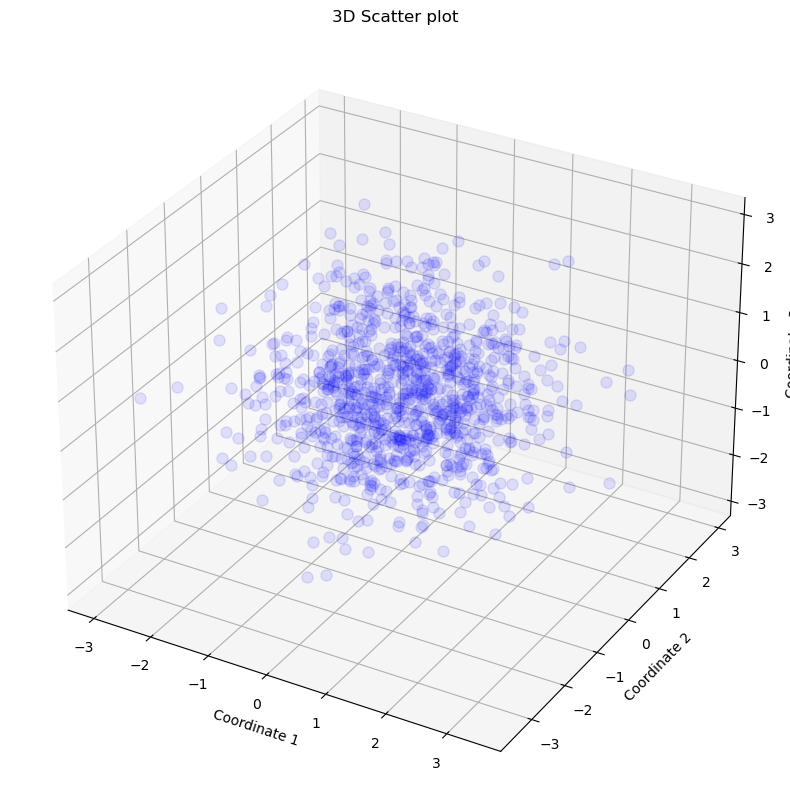

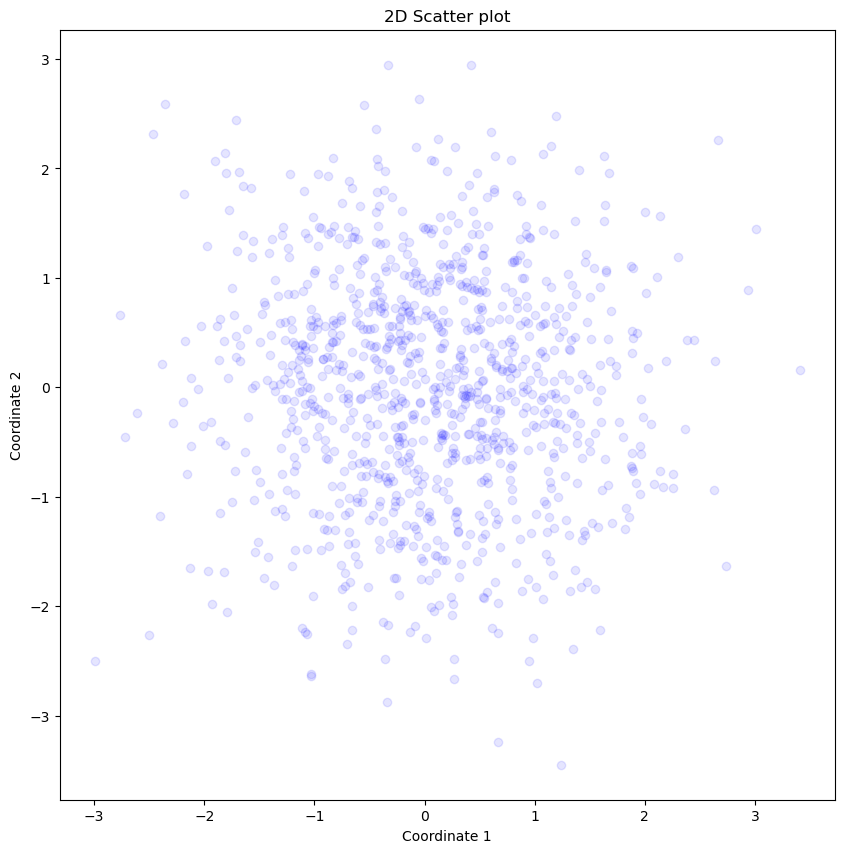

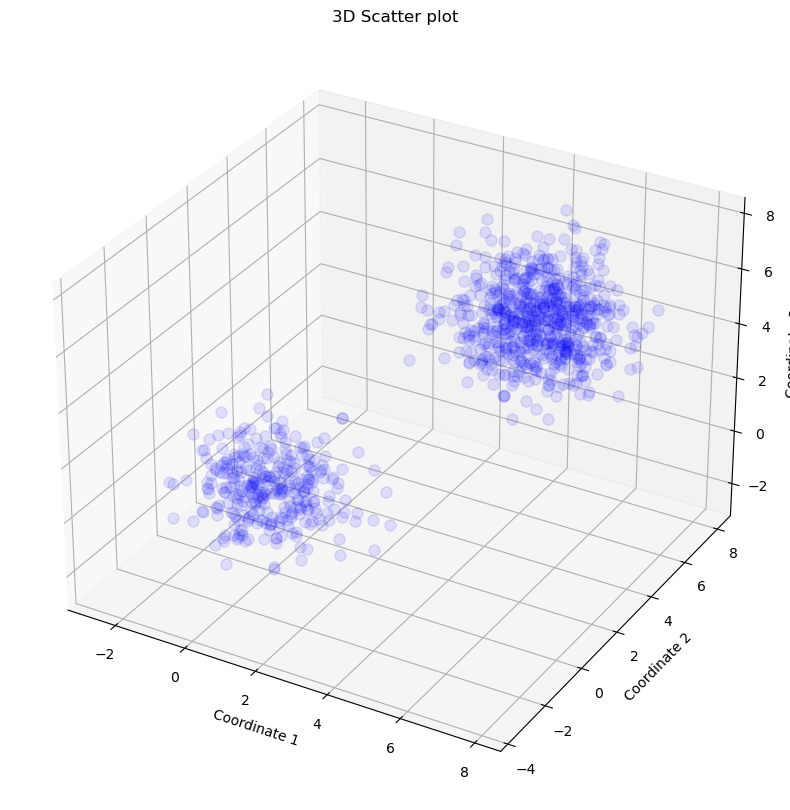

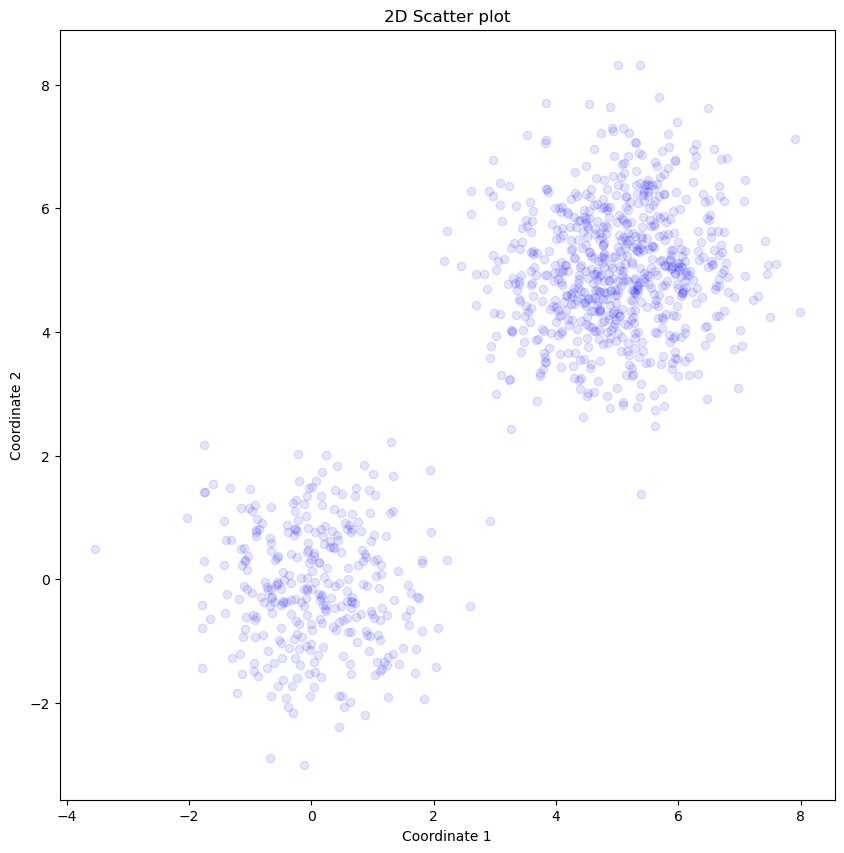

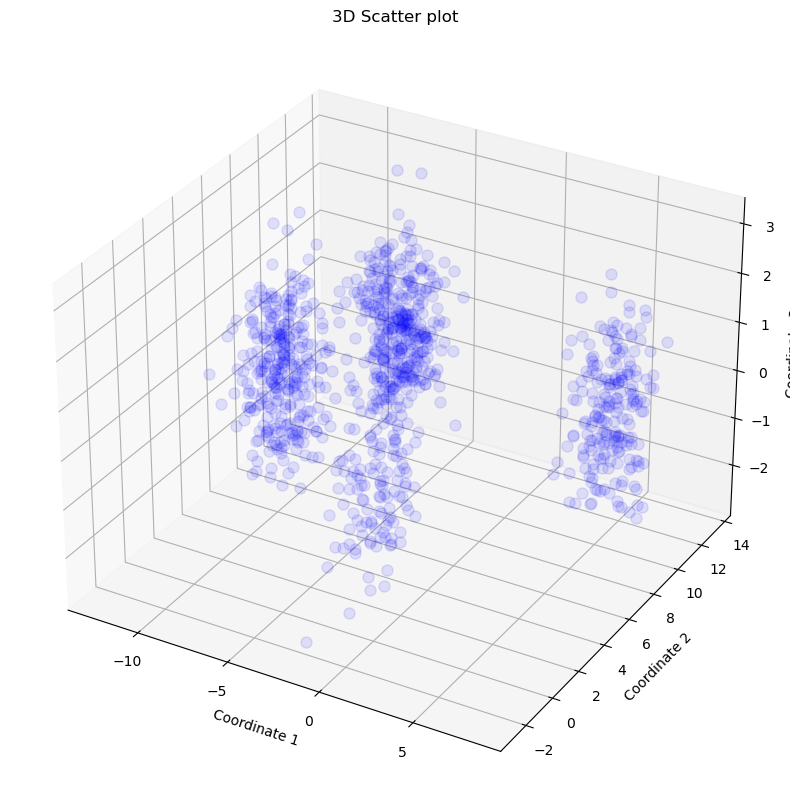

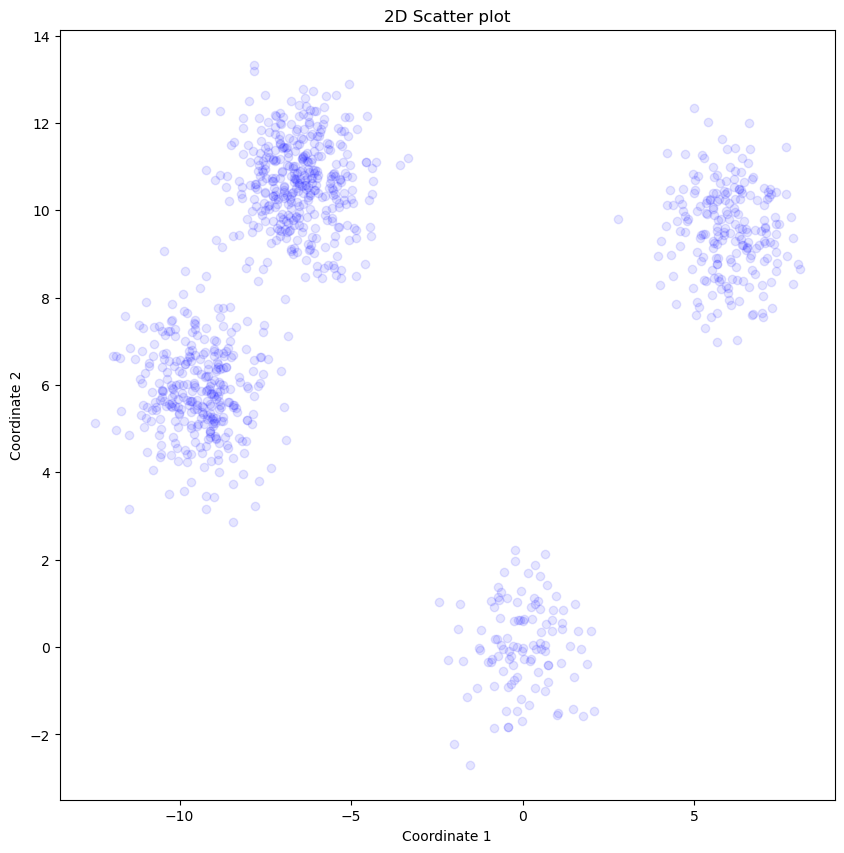

In [19]:
# Your code here
x = data15(5,1000,version = 0)
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, projection='3d')
ax.plot(x[0,:], x[1,:], x[2,:], 'o', markersize=8, color='blue', alpha=0.1)
ax.set_xlabel('Coordinate 1')
ax.set_ylabel('Coordinate 2')
ax.set_zlabel('Coordinate 3')
plt.title('3D Scatter plot')
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(x[0,:], x[1,:], color='blue', alpha=0.1)
plt.title('2D Scatter plot')
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.show()

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, projection='3d')
ax.plot(x[-3,:], x[-2,:], x[-1,:], 'o', markersize=8, color='blue', alpha=0.1)
ax.set_xlabel('Coordinate 1')
ax.set_ylabel('Coordinate 2')
ax.set_zlabel('Coordinate 3')
plt.title('3D Scatter plot')
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(x[-2,:], x[-1,:], color='blue', alpha=0.1)
plt.title('2D Scatter plot')
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.show()

cov = np.cov(data)
e_val, e_vec = np.linalg.eig(cov)
y = np.dot(e_vec.T, x)

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, projection='3d')
ax.plot(y[0,:], y[1,:], y[2,:], 'o', markersize=8, color='blue', alpha=0.1)
ax.set_xlabel('Coordinate 1')
ax.set_ylabel('Coordinate 2')
ax.set_zlabel('Coordinate 3')
plt.title('3D Scatter plot')
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(y[0,:], y[1,:], color='blue', alpha=0.1)
plt.title('2D Scatter plot')
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.show()

__Answer:__ For number 1, there is a cluster near the origin point of either (0,0,0) or (0,0). For part two, there are two well defined clusters. For part there are four well defined data clusters, which might be due getting a new y due to multiolying the original vector with the eigen vector transposed. You can start seeing the four clusters from a signal factor of 5. The clusters become more and more defined as the signal factor increases.

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 2</SPAN>**

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 3:</SPAN>**
Repeat the previous problem, but use data generated by data15(12,1000,1) instead. Briefly compare the results in this question to the results in the previous question.

signal_factor= 12 num_samples= 1000   version= 1


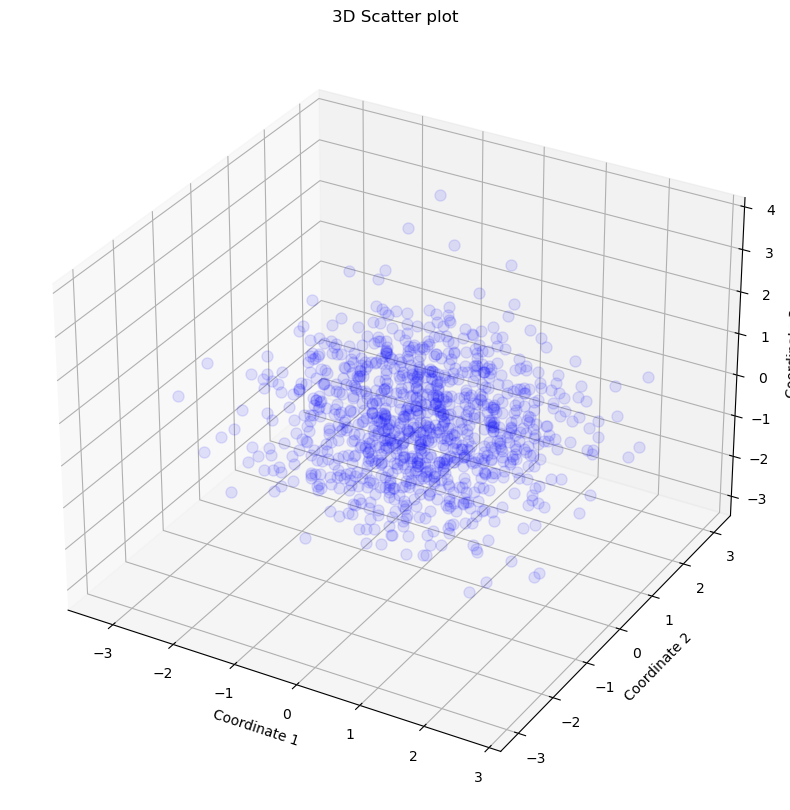

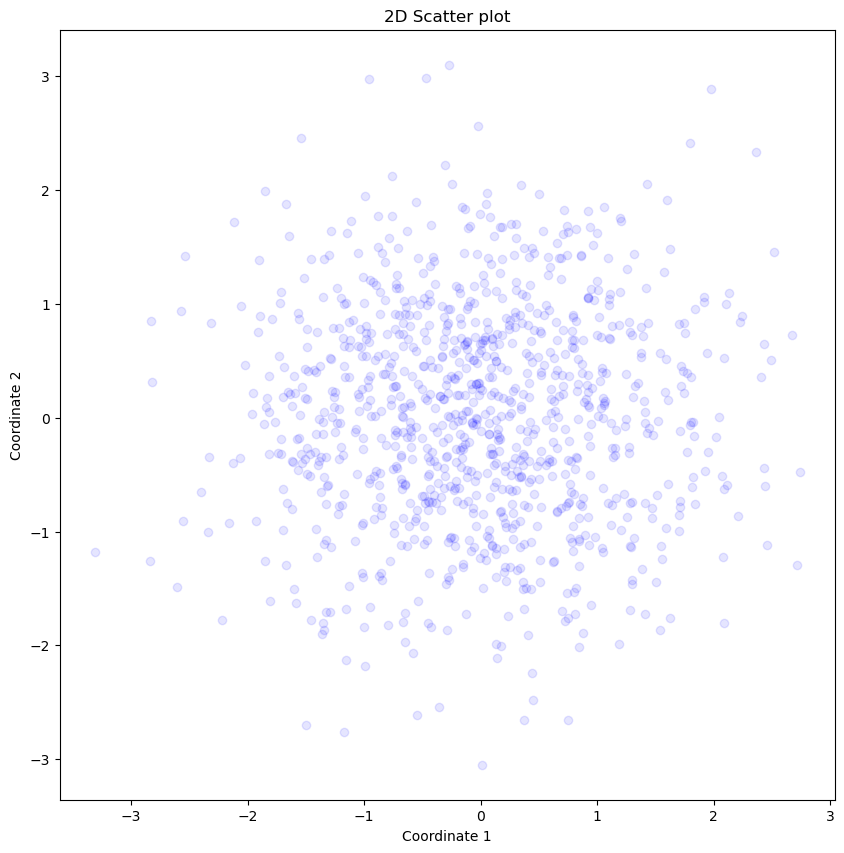

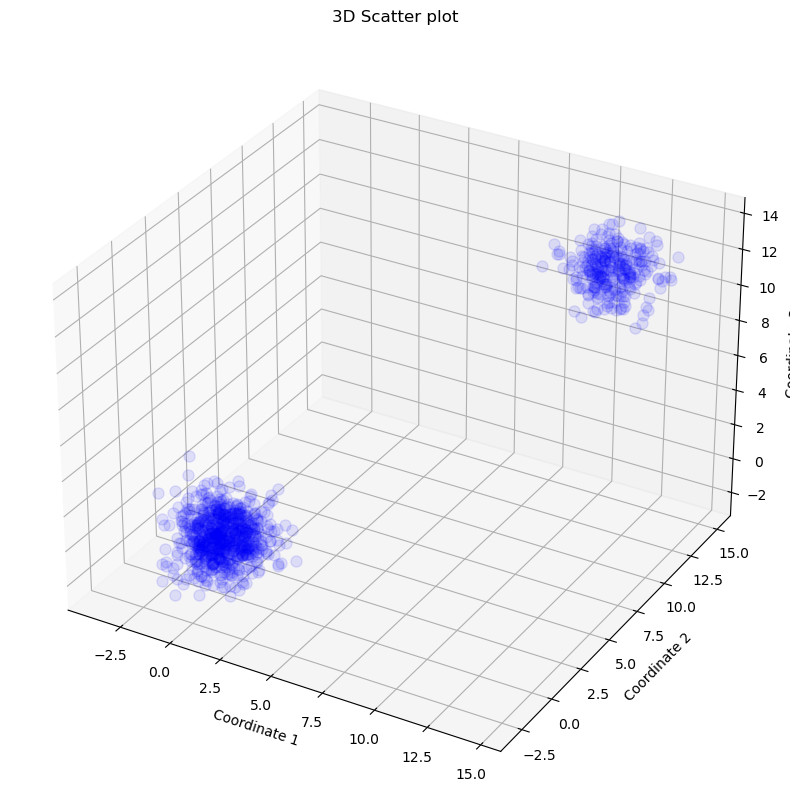

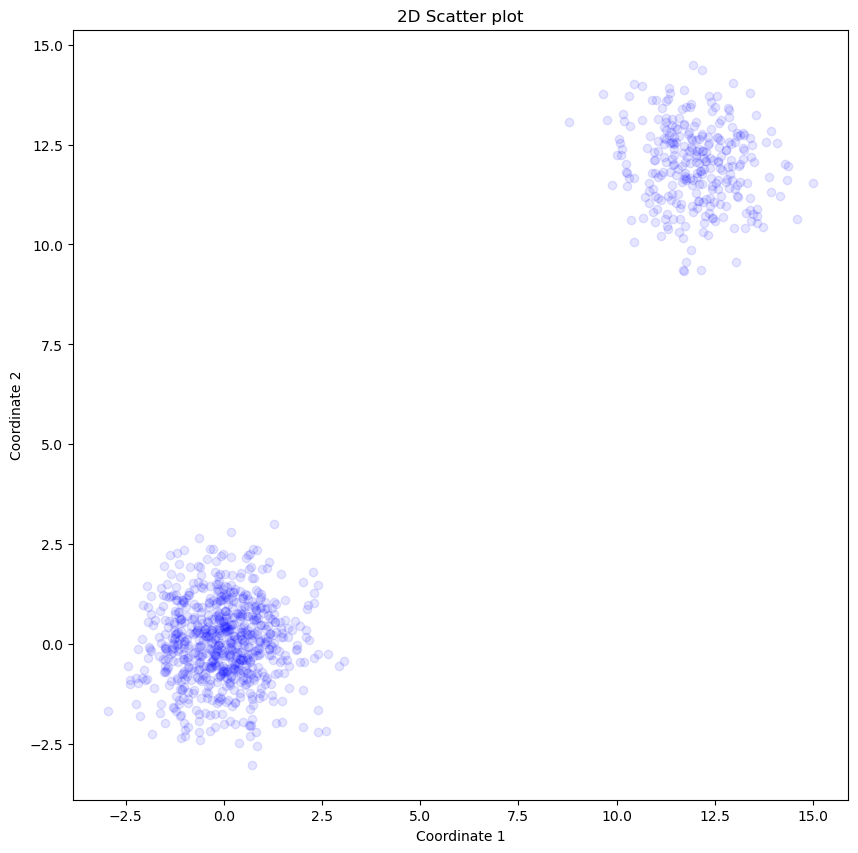

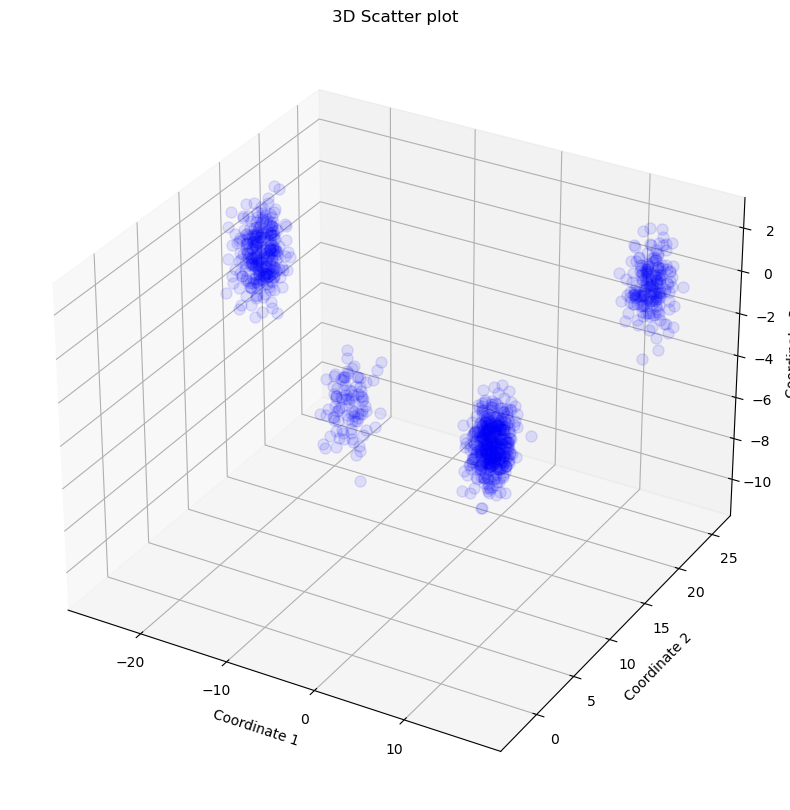

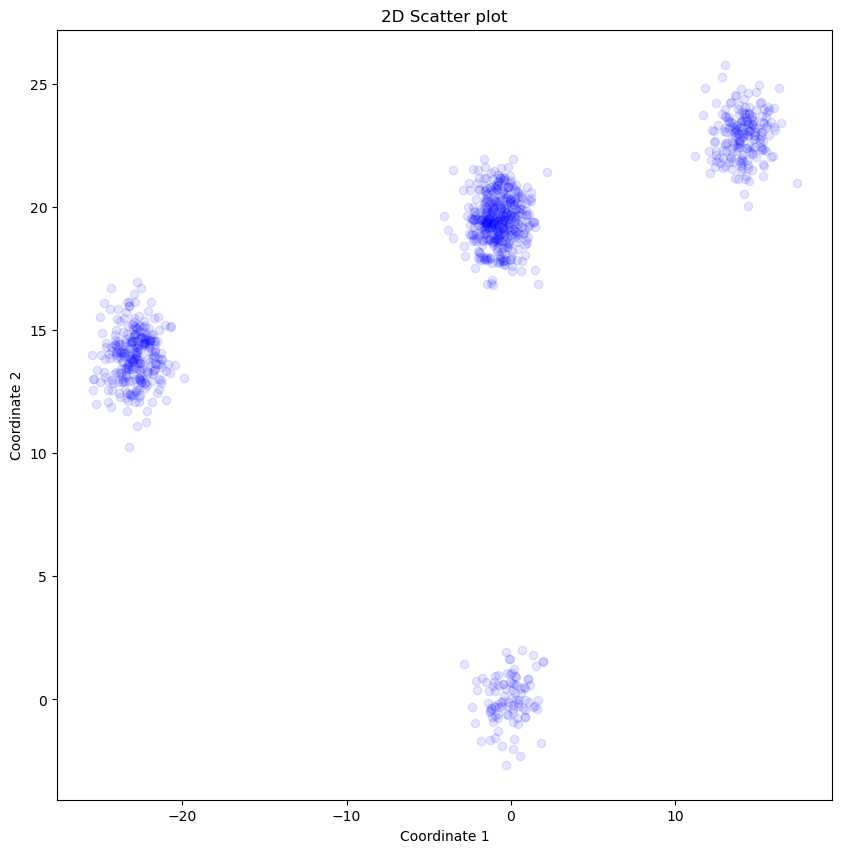

In [16]:
# Your code here
x = data15(12,1000,1)
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, projection='3d')
ax.plot(x[0,:], x[1,:], x[2,:], 'o', markersize=8, color='blue', alpha=0.1)
ax.set_xlabel('Coordinate 1')
ax.set_ylabel('Coordinate 2')
ax.set_zlabel('Coordinate 3')
plt.title('3D Scatter plot')
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(x[0,:], x[1,:], color='blue', alpha=0.1)
plt.title('2D Scatter plot')
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.show()

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, projection='3d')
ax.plot(x[-3,:], x[-2,:], x[-1,:], 'o', markersize=8, color='blue', alpha=0.1)
ax.set_xlabel('Coordinate 1')
ax.set_ylabel('Coordinate 2')
ax.set_zlabel('Coordinate 3')
plt.title('3D Scatter plot')
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(x[-2,:], x[-1,:], color='blue', alpha=0.1)
plt.title('2D Scatter plot')
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.show()

cov = np.cov(data)
e_val, e_vec = np.linalg.eig(cov)
y = np.dot(e_vec.T, x)

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, projection='3d')
ax.plot(y[0,:], y[1,:], y[2,:], 'o', markersize=8, color='blue', alpha=0.1)
ax.set_xlabel('Coordinate 1')
ax.set_ylabel('Coordinate 2')
ax.set_zlabel('Coordinate 3')
plt.title('3D Scatter plot')
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(y[0,:], y[1,:], color='blue', alpha=0.1)
plt.title('2D Scatter plot')
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.show()

__Answer:__ Overall it looks similiar to the previous problem, but the clusters seems to have moved around in a sense. Some clusters seem more defined than the previous problem and some seem less. 

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 3</SPAN>**

In versions 0 and 1 of data15, the variance of the Gaussian part of the data is the same in all directions.  But in many applications the different coordinates could represent measurements in unrelated units and could have drastically different sample variances.   For example, one dimension might represent height in feet, another weight in grams, another temperature in degrees centigrade, and so forth.    In that case the PCA analysis, which identifies the directions in which the data has the greatest variation, could simply pick out which coordinates of the data are measured in the smallest units.   For example, changing distance measurements from kilometers to centimeters increases the variance by $10^{10}$!   To illustrate this, version 2 of data15 uses different variances for the different coordinates of the data.   In the problem, you will still seek to find the clusters.   First, you should check to see what happens without some pre-scaling.

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 4:</SPAN>**  For this problem, analyze data generated data15 version 2:  data15(12,1000,2).   
<ol>
<li>  To see that the nonuniform scaling causes problems, try identifying the clusters using the two or three dimensional plots based on the first two or three coordinates in the dimensions provided by the eigen decomposion of the sample covariance matrix.
<li>  A possible fix is to first standardize the data by dividing the data in each coordinate by the empirical standard deviation for that coordinate.    Note that the covariance matrix for the standardized data is the matrix of correlation coefficients with ones down the diagonal.   Apply the PCA analysis to the standardized data to see if you can detect the cluster structure for much smaller values of signal_factor. 
</ol>

Congratulations on finshing the last lab!

signal_factor= 12 num_samples= 1000   version= 2


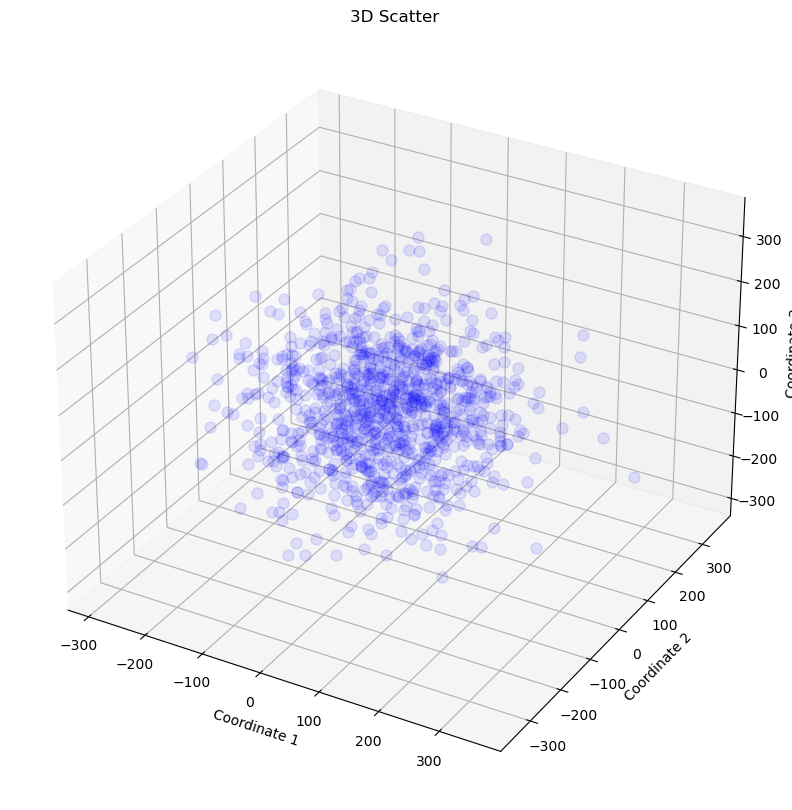

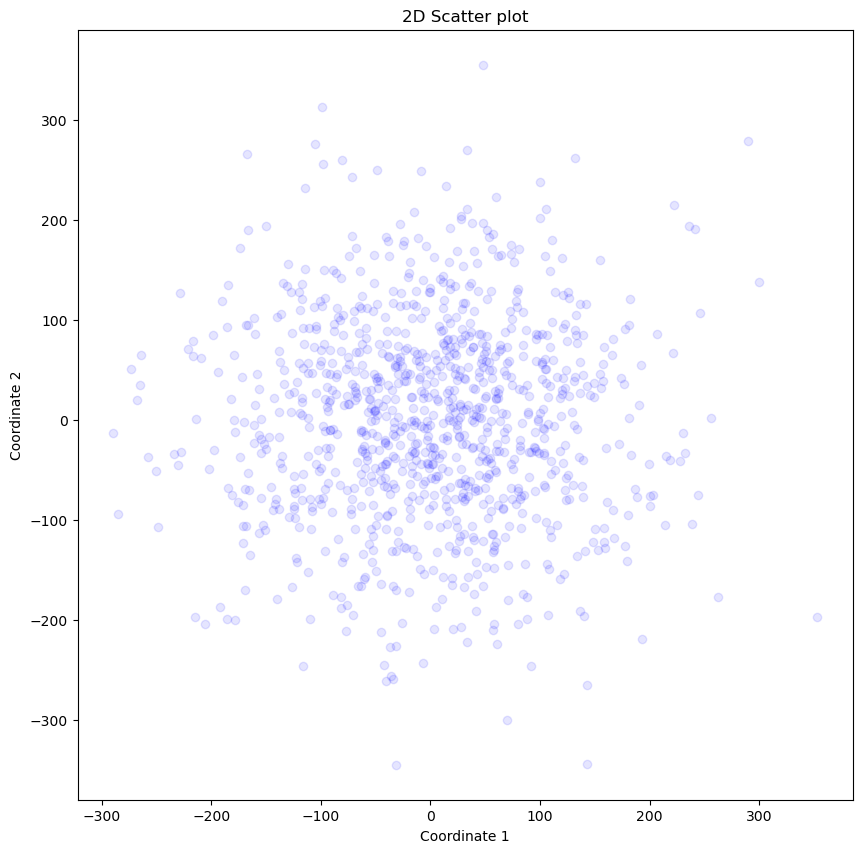

signal_factor= 5 num_samples= 1000   version= 2


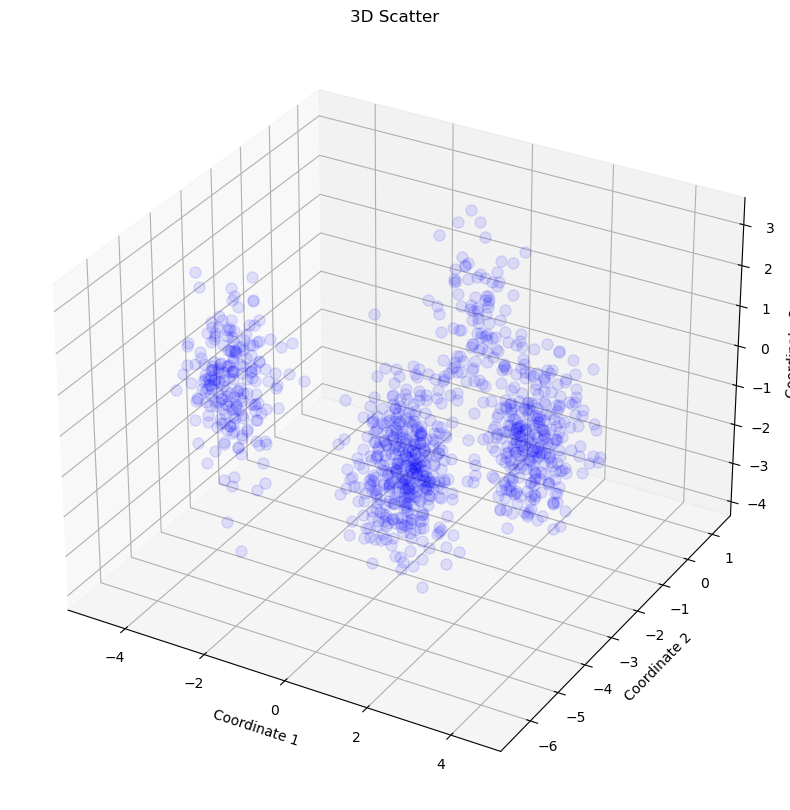

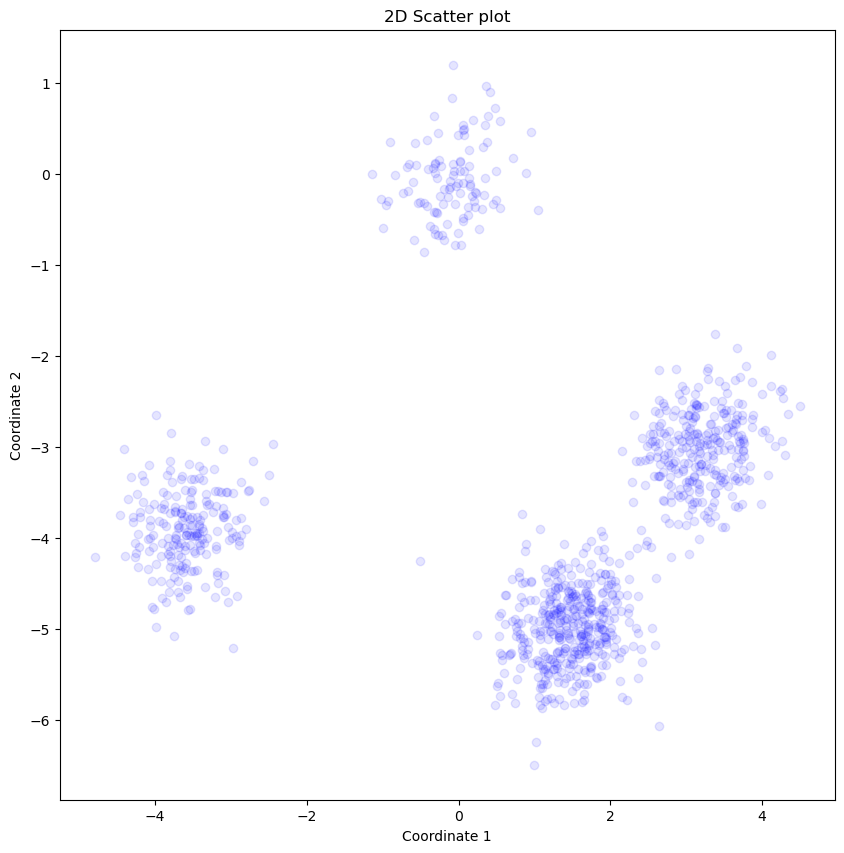

In [18]:
# Your code here
x = data15(12,1000,2)
cov = np.cov(x)
e_val, e_vec = np.linalg.eig(cov)
y = np.dot(e_vec.T, x)

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, projection='3d')
ax.plot(y[0,:], y[1,:], y[2,:], 'o', markersize=8, color='blue', alpha=0.1)
ax.set_xlabel('Coordinate 1')
ax.set_ylabel('Coordinate 2')
ax.set_zlabel('Coordinate 3')
plt.title('3D Scatter')
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(y[0,:], y[1,:], color='blue', alpha=0.1)
plt.title('2D Scatter plot')
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.show()

x=data15(5,1000,2)
x=x/(x.std(1)).reshape(-1,1)
cov = np.cov(x)
e_val, e_vec = np.linalg.eig(cov)
y = np.dot(e_vec.T, x)

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, projection='3d')
ax.plot(y[0,:], y[1,:], y[2,:], 'o', markersize=8, color='blue', alpha=0.1)
ax.set_xlabel('Coordinate 1')
ax.set_ylabel('Coordinate 2')
ax.set_zlabel('Coordinate 3')
plt.title('3D Scatter')
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(y[0,:], y[1,:], color='blue', alpha=0.1)
plt.title('2D Scatter plot')
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.show()

__Answer:__ As you increase the version number it seems that the data clusters get more defined even for lower signal factor values

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 4</SPAN>**

<div class="alert alert-block alert-warning"> 
## Academic Integrity Statement ##

By submitting the lab with this statement, you declare you have written up the lab entirely by yourself, including both code and markdown cells. You also agree that you should not share your code with anyone else. Any violation of the academic integrity requirement may cause an academic integrity report to be filed that could go into your student record. See <a href="https://provost.illinois.edu/policies/policies/academic-integrity/students-quick-reference-guide-to-academic-integrity/">Students' Quick Reference Guide to Academic Integrity</a> for more information. 